In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

teams_data = pd.read_csv("Dataset/teams.csv")
correlation_matrix = teams_data.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = abs(correlation_matrix) < 0.5

# Create a heatmap
plt.figure(figsize=(120, 100))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask)

plt.title('Correlation Heatmap')
plt.show()

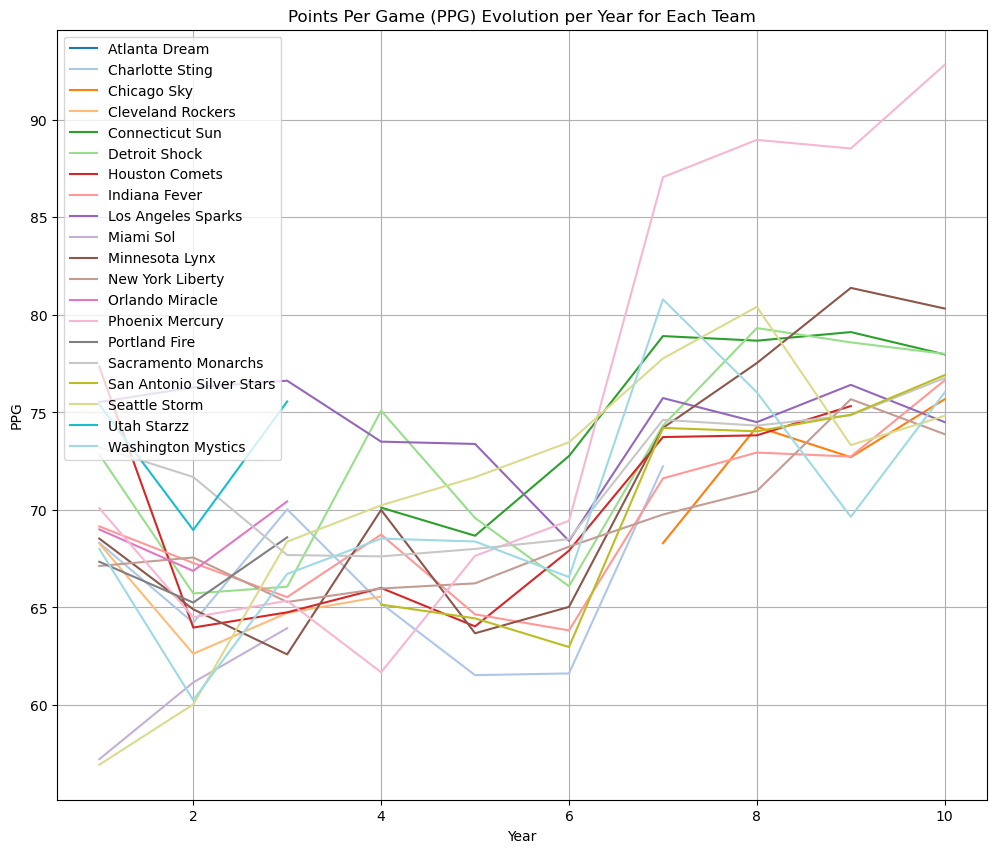

In [66]:
teams_data['PPG'] = teams_data['o_pts'] / teams_data['GP']

ppg_per_team = teams_data.groupby(['name', 'year'])['PPG'].mean().reset_index()

plt.figure(figsize=(12, 10))

colors = plt.cm.tab20([i/len(ppg_per_team['name'].unique()) for i in range(len(ppg_per_team['name'].unique()))])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

for team in ppg_per_team['name'].unique():
    team_data = ppg_per_team[ppg_per_team['name'] == team]
    plt.plot(team_data['year'], team_data['PPG'], label=team)

plt.title('Points Per Game (PPG) Evolution per Year for Each Team')
plt.xlabel('Year')
plt.ylabel('PPG')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [6]:
#Cleaning players_data
   
players_data = pd.read_csv("Dataset/players.csv")
#players_data.dropna(thresh=2, inplace=True)
players_data = players_data[players_data.pos.notnull()]
players_data.drop(players_data[players_data['weight'] < 60].index, inplace = True)
players_data.drop(players_data[players_data['height'] < 50 ].index, inplace = True)
players_data.drop(columns=["firstseason","lastseason","deathDate"],inplace=True)
players_data.reset_index()
players_data.describe()

,height,weight
count,773.000000,773.000000
mean,71.996119,167.701164
std,3.553621,23.953159
min,62.000000,115.000000
25%,69.000000,150.000000
50%,72.000000,166.000000
75%,75.000000,183.000000
max,80.000000,254.000000


In [14]:
teams_data = pd.read_csv("Dataset/teams.csv")


In [16]:
players_teams_data = pd.read_csv("Dataset/players_teams.csv")
awards_players_data = pd.read_csv("Dataset/awards_players.csv")
players_teams_data['awards'] = 0
for idx, player in players_teams_data.iterrows():
    awards_until_target_season = awards_players_data[(awards_players_data['playerID'] == player['playerID']) & (awards_players_data['year'] < player['year'])]
    if(not awards_until_target_season.empty):
        players_teams_data.loc[[idx], 'awards'] =  len(awards_until_target_season)
print(players_teams_data[players_teams_data["awards"]>7] )
for idx, team in teams_data.iterrows():
        team_awards_until_target_season = players_teams_data[(players_teams_data["year"] == team["year"] )&( players_teams_data["tmID"] == team["tmID"])]
        team_awards_num = team_awards_until_target_season["awards"].sum()
        teams_data.loc[[idx], 'awards'] = team_awards_num
teams_data     

        playerID  year  stint tmID  GP  GS  minutes  points  oRebounds  \
910   leslili01w     9      0  LAS  33  33     1059     497         84   
911   leslili01w    10      0  LAS  23  21      638     354         56   
1582  swoopsh01w     8      0  HOU   3   3      106      23          3   
1583  swoopsh01w     9      0  SEA  29  25      706     205         26   

      dRebounds  ...  PostTurnovers  PostPF  PostfgAttempted  PostfgMade  \
910         209  ...             26      29               64          33   
911          95  ...             13      26               84          38   
1582         14  ...              0       0                0           0   
1583        100  ...              5       7               25           8   

      PostftAttempted  PostftMade  PostthreeAttempted  PostthreeMade  PostDQ  \
910                24          15                   4              2       2   
911                39          24                   0              0       1   
1582    

,year,tmID,confID,rank,playoff,firstRound,semis,finals,name,o_fgm,...,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena,awards
0,1,CHA,EA,8,N,NaN,NaN,NaN,Charlotte Sting,812,...,5,11,3,13,5,16,6475,90963,Charlotte Coliseum,0.0
1,2,CHA,EA,4,Y,W,W,L,Charlotte Sting,746,...,11,5,7,9,15,6,6500,105525,Charlotte Coliseum,0.0
2,3,CHA,EA,2,Y,L,NaN,NaN,Charlotte Sting,770,...,11,5,7,9,12,9,6450,106670,Charlotte Coliseum,0.0
3,4,CHA,EA,2,Y,L,NaN,NaN,Charlotte Sting,787,...,13,4,5,12,12,12,6850,120061,Charlotte Coliseum,0.0
4,5,CHA,EA,5,N,NaN,NaN,NaN,Charlotte Sting,745,...,10,7,6,11,8,12,6900,116383,Charlotte Coliseum,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,10,PHO,WE,1,Y,W,W,W,Phoenix Mercury,1128,...,12,5,11,6,13,7,6900,144884,US Airways Center,4.0
137,10,SAC,WE,6,N,NaN,NaN,NaN,Sacramento Monarchs,946,...,7,10,5,12,6,14,6850,131654,ARCO Arena (II),1.0
138,10,SAS,WE,4,Y,L,NaN,NaN,San Antonio Silver Stars,936,...,10,7,5,12,10,10,6950,127957,AT&T Center,2.0
139,10,SEA,WE,2,Y,L,NaN,NaN,Seattle Storm,909,...,13,4,7,10,13,7,7025,133858,KeyArena at Seattle Center,5.0


media de idades, altura e peso
rank/qualificacao na passada
backwards elimination
so variaveis numericas
varios algoritmos

**tabelas**
voltar height pound foot...

